In [1]:
import re
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import IFrame
import matplotlib.font_manager as fm

plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Pulling the data

I will begin by pulling all the shot data from a single game. Below, in the url, one can see I have set the GameID=0021500051 (GSW vs. MEM on Nov. 2, 2015) and the TeamID=1610612744 (GSW). I will use requests library to get the the data from the url.

In [3]:
url = 'http://stats.nba.com/stats/shotchartdetail?'\
        'CFID=&CFPARAMS=&ContextFilter=&ContextMeasure=FGA'\
        '&Counter=1000&DateFrom=&DateTo=&Direction=DESC'\
        '&GameID=0021500051&GameSegment=&LastNGames=0&LeagueID=00'\
        '&Location=&Month=0&OpponentTeamID=0&Outcome=&Period=0'\
        '&PlayerID=0&PlayerOrTeam=T&Position=&RookieYear='\
        '&Season=2015-16&SeasonSegment=&SeasonType=Regular+Season'\
        '&Sorter=PTS&TeamID=1610612744&VsConference=&VsDivision='
response = requests.get(url)
response.json().keys()

[u'resource', u'resultSets', u'parameters']

This is similar to most returned jsons from stats.nba.com. The resource is the name of the resource I am accessing. In this case, it will be 'shotchartdetail'. The resultSets are the values that are returned to me containing the data I requested. The parameters are the relevant parameters issued for this request. Later in this notebook, I will make a request using these parameters in a dict and passing them as an argument in request.get().

Below I explore the keys returned and the relevant information.

In [4]:
resource = response.json()["resource"]
resultSets = response.json()["resultSets"]
parameters = response.json()["parameters"]
print resource
parameters

shotchartdetail


{u'AheadBehind': None,
 u'ClutchTime': None,
 u'ContextFilter': u'',
 u'ContextMeasure': u'FGA',
 u'DateFrom': None,
 u'DateTo': None,
 u'EndPeriod': None,
 u'EndRange': None,
 u'GameID': u'0021500051',
 u'GameSegment': None,
 u'LastNGames': 0,
 u'LeagueID': u'00',
 u'Location': None,
 u'Month': 0,
 u'OpponentTeamID': 0,
 u'Outcome': None,
 u'Period': 0,
 u'PlayerID': 0,
 u'PointDiff': None,
 u'Position': None,
 u'RangeType': None,
 u'RookieYear': None,
 u'Season': u'2015-16',
 u'SeasonSegment': None,
 u'SeasonType': u'Regular Season',
 u'StartPeriod': None,
 u'StartRange': None,
 u'TeamID': 1610612744,
 u'VsConference': None,
 u'VsDivision': None}

In [5]:
print type(resultSets)

<type 'list'>


In [6]:
print len(resultSets)

2


In [7]:
print [type(r) for r in resultSets]

[<type 'dict'>, <type 'dict'>]


In [8]:
print [r.keys() for r in resultSets]

[[u'headers', u'rowSet', u'name'], [u'headers', u'rowSet', u'name']]


In [9]:
[r['name'] for r in resultSets]

[u'Shot_Chart_Detail', u'LeagueAverages']

Great! This is like most resultSets returned from the stats.nba.com, where the first dict is the data on the player or team, and the second dict contains the league averages. Very useful!

Let's see what kind of data lies within 'Shot_Chart_Detail': 

In [10]:
resultSets[0]['headers']

[u'GRID_TYPE',
 u'GAME_ID',
 u'GAME_EVENT_ID',
 u'PLAYER_ID',
 u'PLAYER_NAME',
 u'TEAM_ID',
 u'TEAM_NAME',
 u'PERIOD',
 u'MINUTES_REMAINING',
 u'SECONDS_REMAINING',
 u'EVENT_TYPE',
 u'ACTION_TYPE',
 u'SHOT_TYPE',
 u'SHOT_ZONE_BASIC',
 u'SHOT_ZONE_AREA',
 u'SHOT_ZONE_RANGE',
 u'SHOT_DISTANCE',
 u'LOC_X',
 u'LOC_Y',
 u'SHOT_ATTEMPTED_FLAG',
 u'SHOT_MADE_FLAG']

In [11]:
resultSets[0]['rowSet'][0]

[u'Shot Chart Detail',
 u'0021500051',
 4,
 203084,
 u'Harrison Barnes',
 1610612744,
 u'Golden State Warriors',
 1,
 11,
 27,
 u'Missed Shot',
 u'Turnaround Jump Shot',
 u'2PT Field Goal',
 u'Mid-Range',
 u'Left Side(L)',
 u'8-16 ft.',
 11,
 -110,
 46,
 1,
 0]

Let's load the `resultSets[0]` into a dataframe using the header for column labels

In [12]:
sc_df = pd.DataFrame(resultSets[0]['rowSet'],columns=resultSets[0]['headers'])
sc_df.head(8)

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
0,Shot Chart Detail,0021500051,4,203084,Harrison Barnes,1610612744,Golden State Warriors,1,11,27,Missed Shot,Turnaround Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),8-16 ft.,11,-110,46,1,0
1,Shot Chart Detail,0021500051,11,201939,Stephen Curry,1610612744,Golden State Warriors,1,10,36,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,28,-210,188,1,1
2,Shot Chart Detail,0021500051,13,203110,Draymond Green,1610612744,Golden State Warriors,1,10,5,Made Shot,Jump Shot,3PT Field Goal,Above the Break 3,Left Side Center(LC),24+ ft.,26,-173,203,1,1
3,Shot Chart Detail,0021500051,17,201939,Stephen Curry,1610612744,Golden State Warriors,1,9,34,Made Shot,Running Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,20,-160,120,1,1
4,Shot Chart Detail,0021500051,26,203084,Harrison Barnes,1610612744,Golden State Warriors,1,8,35,Missed Shot,Turnaround Jump Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,3,22,26,1,0
5,Shot Chart Detail,0021500051,29,201939,Stephen Curry,1610612744,Golden State Warriors,1,8,5,Missed Shot,Jump Shot,3PT Field Goal,Above the Break 3,Center(C),24+ ft.,24,-20,247,1,0
6,Shot Chart Detail,0021500051,38,202691,Klay Thompson,1610612744,Golden State Warriors,1,7,25,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,21,86,193,1,1
7,Shot Chart Detail,0021500051,43,202691,Klay Thompson,1610612744,Golden State Warriors,1,6,47,Made Shot,Jump Shot,2PT Field Goal,Mid-Range,Right Side(R),16-24 ft.,16,161,21,1,1


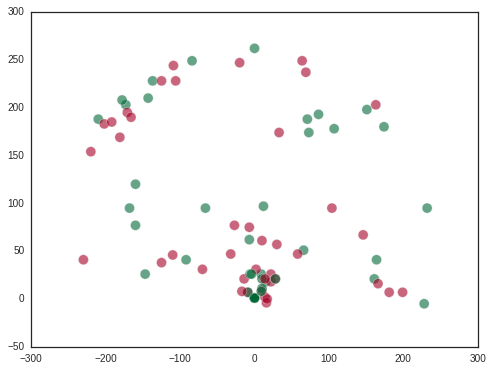

In [13]:
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(8, 6))
scat = plt.scatter(x=sc_df.LOC_X,y=sc_df.LOC_Y,c=sc_df.SHOT_MADE_FLAG,
    cmap=plt.cm.RdYlGn, s=100, alpha=.6)
plt.show()

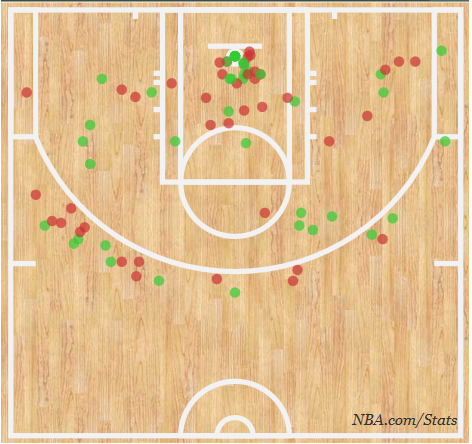

In [14]:
from IPython.display import Image
Image('img/example_nba_shotchart.png')

Okay, so we can see that the court is flipped on the NBA website. So I will flip my y-axis

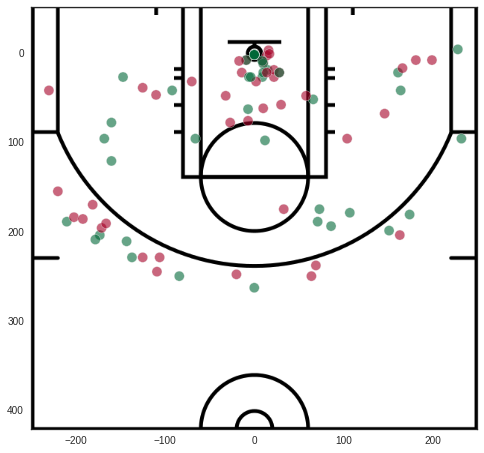

In [15]:
plt.style.use('seaborn-white')

fig,ax = plt.subplots(figsize=(8, 8))
scat = plt.scatter(x=sc_df.LOC_X,y=sc_df.LOC_Y,c=sc_df.SHOT_MADE_FLAG,
    cmap=plt.cm.RdYlGn, s=100, alpha=.6, zorder=1)
ax.invert_yaxis()

plt.style.use('grayscale')
#Read in the half court image
court = plt.imread("img/halfcourt.png")
#The baseline is 4 ft. from front of backboard. front of backboard is 15 in. from center of hoop (the origin).
#Therefore, my image extent needs to go from (4ft.+15in.) = 5.25 ft. so 52.5 ft. in the coordinate system.
img = plt.imshow(court, zorder=0, extent=[-250,250,420,-52.5])

plt.show()

Great, I can make sense and plot the data from nba.com.  Now I will get shot data for all players for the 2015-16 season and determine the best shooter from each zone.

Steps
1. Pull shot data for all players
2. Parse the data into a table with rows of players, columns of zone1_attempts zone1_made, etc.
3. Calculate best for each zone

Below, I expose a bit more about the nba stats API. I setup a dict of the required parameters to the shotchartdetail call. I set TeamID, GameID, and PlayerID to 0. With Season set to 2015-16, I will pull all the shot data for the regular season so far. Initially, I was going to pull each player with separate calls, but this is much better (and makes a lot fewer requests for the site).

In [16]:
sc_params = {u'AheadBehind': u'',
 u'ClutchTime': u'',
 u'ContextFilter': u'',
 u'ContextMeasure': u'FGA',
 u'DateFrom': u'',
 u'DateTo': u'',
 u'EndPeriod': u'',
 u'EndRange': u'',
 u'GameID': u'',
 u'GameSegment': u'',
 u'LastNGames': 0,
 u'LeagueID': u'00',
 u'Location': u'',
 u'Month': 0,
 u'OpponentTeamID': 0,
 u'Outcome': u'',
 u'Period': 0,
 u'PlayerID': 0,
 u'PointDiff': u'',
 u'Position': u'',
 u'RangeType': u'',
 u'RookieYear': u'',
 u'Season': u'2015-16',
 u'SeasonSegment': u'',
 u'SeasonType': u'Regular Season',
 u'StartPeriod': u'',
 u'StartRange': u'',
 u'TeamID': 0,
 u'VsConference': u'',
 u'VsDivision': u''}

baseurl = 'http://stats.nba.com/stats/shotchartdetail?'
resp2 = requests.get(baseurl,params=sc_params)
print resp2.url
print resp2.json().keys()

http://stats.nba.com/stats/shotchartdetail?PlayerID=0&StartPeriod=&StartRange=&TeamID=0&VsConference=&Location=&SeasonType=Regular+Season&RangeType=&RookieYear=&Season=2015-16&DateFrom=&ClutchTime=&EndPeriod=&EndRange=&ContextFilter=&GameID=&OpponentTeamID=0&DateTo=&GameSegment=&AheadBehind=&PointDiff=&LastNGames=0&VsDivision=&LeagueID=00&Position=&Outcome=&ContextMeasure=FGA&SeasonSegment=&Period=0&Month=0
[u'resource', u'resultSets', u'parameters']


##### player_shot_df = pd.DataFrame(resp2.json()['resultSets'][0]['rowSet'],columns=resp2.json()['resultSets'][0]['headers'])
print player_shot_df.shape
player_shot_df.head(5)

### Plot all the shots

Now, I will plot all of the shots so far this season. I changed the court to be black and used yellow for the made shots and blue for the misses. This makes the misses stand out more, and is more color-blind friendly than red/green plots.

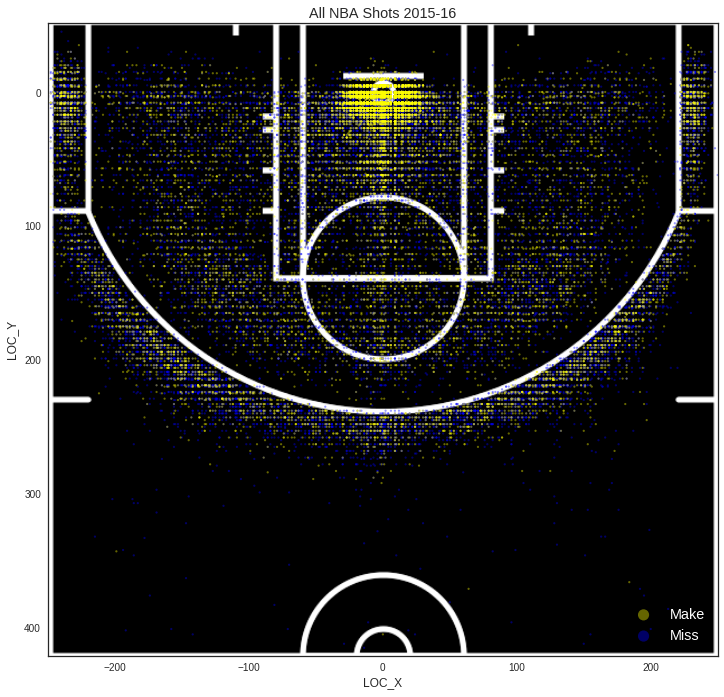

In [18]:
plt.style.use('seaborn-white')
fig,ax = plt.subplots(figsize=(12, 12))

keepxy = ['LOC_X','LOC_Y']
made_index = (player_shot_df['SHOT_MADE_FLAG']==1)
made_df = player_shot_df.loc[made_index][keepxy]
miss_df = player_shot_df.loc[~made_index][keepxy]

made_df.plot(kind='scatter', x='LOC_X',y='LOC_Y',color='Yellow',
             s=5, alpha=.4, edgecolors='none', zorder=2,ax=ax,
            label='Make')
miss_df.plot(kind='scatter', x='LOC_X',y='LOC_Y',color='Blue',
             s=5, alpha=.4, edgecolors='none', zorder=1,ax=ax,
            label='Miss')
                             
ax.invert_yaxis()

# Set legend to lower right, x-large text, and larger markerscale
leg = ax.legend(loc='lower right',fontsize='x-large',markerscale=5)
labls = leg.get_texts()
[x.set_color('white') for x in labls]

#Read in the half court image
court = plt.imread("img/halfcourt.png")
#The baseline is 4 ft. from front of backboard. front of backboard is 15 in. from center of hoop (the origin).
#Therefore, my image extent needs to go from (4ft.+15in.) = 5.25 ft. so 52.5 ft. in the coordinate system.
img = plt.imshow(court, zorder=0, extent=[-250,250,420,-52.5])

plt.title('All NBA Shots 2015-16',fontsize='x-large')
plt.savefig('img/NBA_shotchart_2015-16.png',dpi=300)
plt.show()

256


<function matplotlib.pyplot.show>

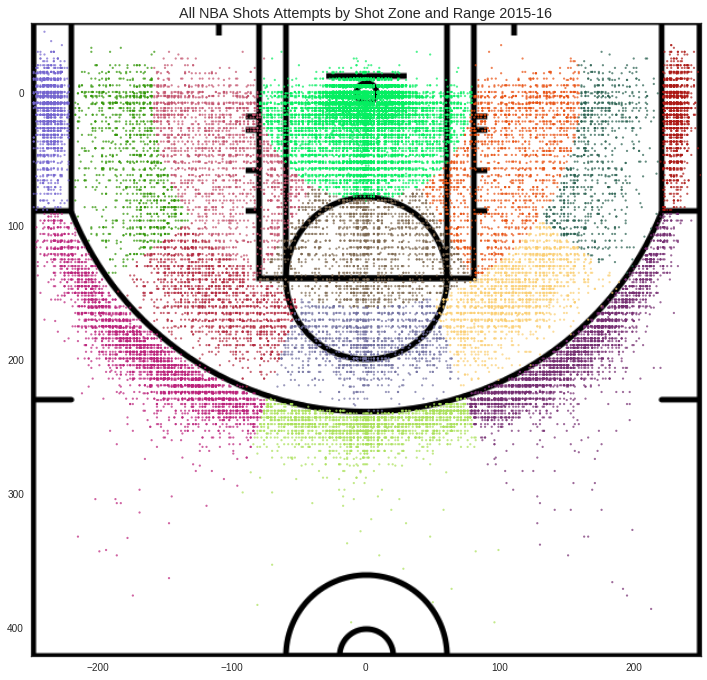

In [19]:
ZAs = player_shot_df.SHOT_ZONE_AREA.unique()
ZRs = player_shot_df.SHOT_ZONE_RANGE.unique()[:-1] #-1 to avoid Backcourt shots

fig,ax = plt.subplots(figsize=(12, 12))
colrs = np.random.random((len(ZAs)*len(ZRs),4))
cmap = plt.get_cmap()
print cmap.N
cnum=0
for za in ZAs:
    for zr in ZRs:
        bin_mask = (player_shot_df['SHOT_ZONE_AREA']==za) & (player_shot_df['SHOT_ZONE_RANGE']==zr)
        if np.sum(bin_mask) > 0:
            cnum+=1
            plt.scatter(x=player_shot_df[bin_mask]['LOC_X'],y=player_shot_df[bin_mask]['LOC_Y'],c=colrs[cnum],
             s=5, alpha=.7, edgecolors='none', zorder=2,label=za+zr)
ax.invert_yaxis()

#Read in the half court image
plt.style.use('grayscale')
court = plt.imread("img/halfcourt.png")
#The baseline is 4 ft. from front of backboard. front of backboard is 15 in. from center of hoop (the origin).
#Therefore, my image extent needs to go from (4ft.+15in.) = 5.25 ft. so 52.5 ft. in the coordinate system.
img = plt.imshow(court, zorder=0, extent=[-250,250,420,-52.5])
plt.title('All NBA Shots Attempts by Shot Zone and Range 2015-16',fontsize='x-large')
plt.savefig('img/NBA_shotzonerange_2015-16.png',dpi=300)
plt.show

Close enough. The out-of-bounds lines are actually inside the bounds of the court. I can work on drawing the court very carefully in another notebook.

Here is a summary of shot types (2pt,3pt), shot zone areas (L,LC,C,RC,L), and shot zone ranges (<8,8-16,16-24,>24)

In [20]:
keepfields=['SHOT_TYPE','SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']
shot_type_zone_df = player_shot_df[keepfields].groupby(['SHOT_TYPE','SHOT_ZONE_AREA']).sum()
shot_type_zone_df = shot_type_zone_df.assign(SHOT_MADE_FLAG = shot_type_zone_df['SHOT_MADE_FLAG']/shot_type_zone_df['SHOT_ATTEMPTED_FLAG'])
shot_type_zone_df

SHOT_ATTEMPTED_FLAG  SHOT_MADE_FLAG
SHOT_TYPE      SHOT_ZONE_AREA                                            
2PT Field Goal Center(C)                            18930        0.523138
               Left Side Center(LC)                  1525        0.394754
               Left Side(L)                          2865        0.382897
               Right Side Center(RC)                 1554        0.391248
               Right Side(R)                         2570        0.380156
3PT Field Goal Back Court(BC)                          87        0.045977
               Center(C)                             1971        0.341958
               Left Side Center(LC)                  3082        0.335172
               Left Side(L)                          1383        0.381779
               Right Side Center(RC)                 2821        0.348812
               Right Side(R)                         1307        0.358072

__NOTE:__ An earlier version had a 2PT back court shot. It has since been corrected in the nba stats database. I leave the next few lines here because it won't effect the data and stands as a reminder to check data and correct it.

Hmm. A 2 PT back court shot? I can't think of a scenario where that could occur.
I will investigate and clean this up.

In [21]:
bad_code = player_shot_df[(player_shot_df['SHOT_TYPE']=='2PT Field Goal') & (player_shot_df['SHOT_ZONE_AREA']=='Back Court(BC)')]
bad_code

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG


In [22]:
#It is clearly a 3PT shot (based on distance, x, and y)
player_shot_df.loc[bad_code.index,'SHOT_TYPE']='3PT Field Goal'
#See if any shots with distance > 24 ft. are marked as 2 PT
player_shot_df[(player_shot_df['SHOT_TYPE']=='2PT Field Goal') & (player_shot_df['SHOT_DISTANCE']>=24)]

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG


I will examine some other fields to make sure things are in order.

In [23]:
player_shot_df['ACTION_TYPE'].value_counts()

Jump Shot                             18677
Layup Shot                             3602
Driving Layup Shot                     2255
Pullup Jump shot                       1967
Floating Jump shot                      976
Step Back Jump shot                     804
Hook Shot                               793
Tip Layup Shot                          749
Running Layup Shot                      658
Turnaround Jump Shot                    653
Dunk Shot                               597
Cutting Layup Shot                      541
Fadeaway Jump Shot                      490
Running Jump Shot                       462
Putback Layup Shot                      382
Driving Finger Roll Layup Shot          373
Reverse Layup Shot                      369
Jump Bank Shot                          344
Turnaround Hook Shot                    285
Driving Floating Jump Shot              275
Driving Reverse Layup Shot              267
Alley Oop Dunk Shot                     243
Turnaround Fadeaway shot        

What a mess! Just some of the issues here:
* seems to be a lot of 'Driving' and 'Running' shots with very little difference between them
* 'No Shot' shots? That can't be correct
* [sS]hot needs to be standardized
* Some descriptives seem very subjective

Use some regex to clean it up and see the proportions of each action type

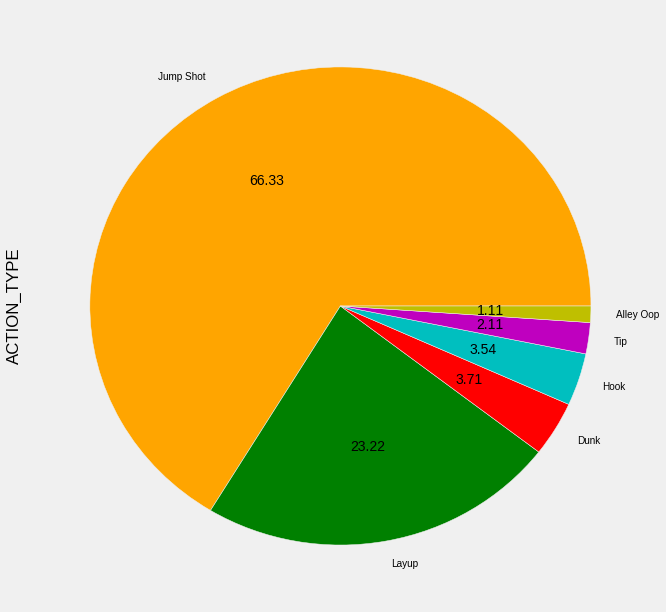

In [24]:
import re
from collections import OrderedDict

def clean_action_type(text):
    text=re.sub(u'shot',u'Shot',text)
    text=re.sub(u'Driving |Running |Cutting ',u'',text)
    text=re.sub(u'Pullup |Pull-Up |Step Back |Turnaround |Putback |Floating |Finger Roll |Reverse ',u'',text)
    text=re.sub(u'Tip Layup Shot|Tip Dunk Shot',u'Tip',text)
    text=re.sub(u'Alley Oop Dunk Shot|Alley Oop Layup Shot',u'Alley Oop',text)
    text=re.sub(u'Fadeaway Shot|Fadeaway Bank Shot|Fadeaway Bank Jump Shot',u'Fadeaway Jump Shot',text)
    text=re.sub(u'Bank Jump Shot|Jump Bank Shot|Bank Shot|Fadeaway Jump Shot',u'Jump Shot',text)
    text=re.sub(u'Bank Hook Shot|Hook Bank Shot|Hook Jump Shot',u'Hook Shot',text)
    return text

def categorize_action_type(text):
    keywords = OrderedDict()
    keywords["Alley Oop"] = ["Alley Oop"] #alley oop first (so alley oop dunks -> alley oop and not dunk)
    keywords["Tip"] = ["Tip"] #tip next
    keywords["Dunk"] = ["Dunk"]
    keywords["Layup"] = ["Layup"]
    keywords["Hook"] = ["Hook"]
    keywords["Jump Shot"] = ["Jump","Fadeaway"]
    
    keywords_res = OrderedDict()
    for k in keywords:
        pat = "\\b%s\\b" % "\\b|\\b".join(keywords[k])
        keywords_res[k] = re.compile(pat, re.IGNORECASE)
    
    for r in keywords_res:
        if keywords_res[r].search(text): return r
    return "Other"
    
#action_counts = player_shot_df['ACTION_TYPE'].map(lambda x: clean_action_type(x)).value_counts()
action_counts = player_shot_df['ACTION_TYPE'].map(lambda x: categorize_action_type(x)).value_counts()

#plt.style.use('seaborn-white')
plt.style.use('fivethirtyeight')

#action_counts.drop('No Shot').plot(kind='pie',figsize=(8,8),autopct='%.2f',colors=['b','g','r','c','m','y','gray','orange'])
action_counts.drop('Other').plot(kind='pie',figsize=(10,10),autopct='%.2f',colors=['orange','g','r','c','m','y','gray'])

Unsurprisingly, jump shots are most common.

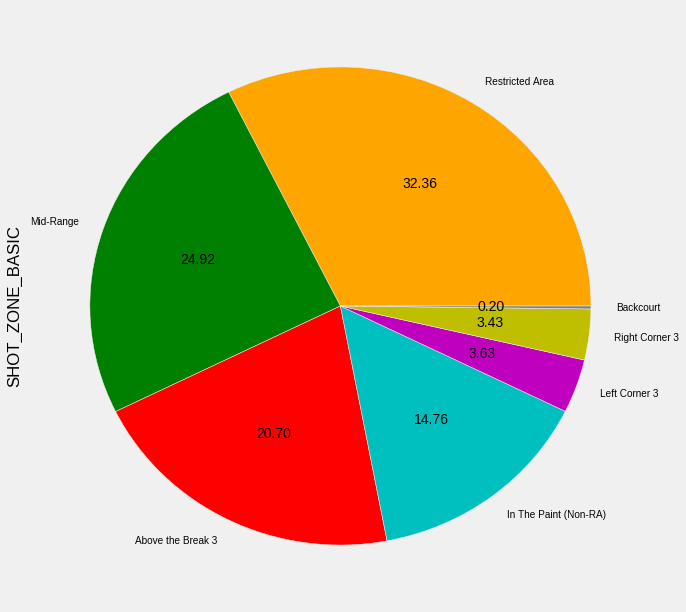

In [25]:
player_shot_df['SHOT_ZONE_BASIC'].value_counts().plot(kind='pie',figsize=(10,10),autopct='%.2f',colors=['orange','g','r','c','m','y','gray'])

### No shot

__NOTE:__ There were about 21 'Not Shot' events when I first pulled this data. Like the 2PT back court shot above, this has been corrected in the nba stats database since my last exploration. This is great, but I will leave the code below untouched so you may see my process.

To see what is going on with the 'No Shot' action types, I will filter the data frame.

In [38]:
player_shot_df[player_shot_df['ACTION_TYPE']=='No Shot']

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,EVENT_TYPE,ACTION_TYPE,SHOT_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG
17578,Shot Chart Detail,0021500104,34,203105,Festus Ezeli,1610612744,Golden State Warriors,1,6,51,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,0,1,1,1
17580,Shot Chart Detail,0021500104,37,202704,Reggie Jackson,1610612765,Detroit Pistons,1,6,23,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,10,7,1,1
17588,Shot Chart Detail,0021500104,59,101106,Andrew Bogut,1610612744,Golden State Warriors,1,4,16,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,2,-7,21,1,0
17589,Shot Chart Detail,0021500104,61,101106,Andrew Bogut,1610612744,Golden State Warriors,1,4,14,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-4,7,1,1
17613,Shot Chart Detail,0021500104,135,2733,Shaun Livingston,1610612744,Golden State Warriors,2,8,35,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,-9,2,1,0
17623,Shot Chart Detail,0021500104,168,201578,Marreese Speights,1610612744,Golden State Warriors,2,6,23,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,6,13,1,0
17625,Shot Chart Detail,0021500104,173,203382,Aron Baynes,1610612765,Detroit Pistons,2,6,10,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,3,0,1,0
17689,Shot Chart Detail,0021500104,351,101106,Andrew Bogut,1610612744,Golden State Warriors,3,1,50,Missed Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,1,4,1,0
17690,Shot Chart Detail,0021500104,353,101106,Andrew Bogut,1610612744,Golden State Warriors,3,1,49,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,0,1,7,1,1
17694,Shot Chart Detail,0021500104,367,101106,Andrew Bogut,1610612744,Golden State Warriors,3,0,48,Made Shot,No Shot,2PT Field Goal,Restricted Area,Center(C),Less Than 8 ft.,1,-11,16,1,1


These are games from the same recent night, that perhaps have not yet been correctly coded. To view them, I will write out links to the video of each event. 

In [39]:
def game_event_id_video_link(gid,gevid):
    if isinstance(gid,int):
        gid = str(gid)
    if isinstance(gevid,int):
        gevid = str(gevid)
    return 'http://stats.nba.com/cvp.html?GameID='+gid+'&GameEventID='+gevid

for f,row in player_shot_df[player_shot_df['ACTION_TYPE']=='No Shot'].iterrows():
    print game_event_id_video_link(row['GAME_ID'],row['GAME_EVENT_ID'])

http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=34
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=37
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=59
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=61
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=135
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=168
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=173
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=351
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=353
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=367
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=456
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=483
http://stats.nba.com/cvp.html?GameID=0021500104&GameEventID=476
http://stats.nba.com/cvp.html?GameID=0021500105&GameEventID=11
http://stats.nba.com/cvp.html?GameID=0021500105&GameEventID=23
http://stats.nba.com/cvp.html?GameID=002150010

Looking at them, these 'No Shots' are actual shots (dunks,layups,etc.). I'll remove the 'No Shot's from any plots that use it. Otherwise, the other data appears to be correct (x and y loc, areas), so I will keep it in. If I was going to do something serious with the action types, I could code them myself by watching the videos. 

### Top 10 FG% per shot zone
I will apply a groupby function on the data to parse out the number of made and number of attempted shots for each shot zone, for each player.

In [26]:
keepfields = ['PLAYER_ID','PLAYER_NAME','TEAM_NAME','SHOT_TYPE','SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']
shot_zones_df=player_shot_df[keepfields].groupby(['PLAYER_ID','PLAYER_NAME','TEAM_NAME','SHOT_TYPE','SHOT_ZONE_AREA','SHOT_ZONE_RANGE']).sum()
shot_zones_df.head(15)

SHOT_ATTEMPTED_FLAG  \
PLAYER_ID PLAYER_NAME   TEAM_NAME              SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                        
708       Kevin Garnett Minnesota Timberwolves 2PT Field Goal Center(C)             16-24 ft.                          4   
                                                                                    8-16 ft.                           3   
                                                                                    Less Than 8 ft.                    8   
                                                              Left Side Center(LC)  16-24 ft.                          6   
                                                              Left Side(L)          16-24 ft.                          3   
                                                                                    8-16 ft.                           3   
                                                              Right Side Center(RC) 16-24 ft.                          6   
                                                              Right Side(R)         16-24 ft.                          4   
                                                                                    8-16 ft.                           1   
977       Kobe Bryant   Los Angeles Lakers     2PT Field Goal Center(C)             16-24 ft.                          8   
                                                                                    8-16 ft.                           6   
                                                                                    Less Than 8 ft.                   29   
                                                              Left Side Center(LC)  16-24 ft.                          7   
                                                              Left Side(L)          16-24 ft.                          5   
                                                                                    8-16 ft.                          14   

                                                                                                     SHOT_MADE_FLAG  
PLAYER_ID PLAYER_NAME   TEAM_NAME              SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                  
708       Kevin Garnett Minnesota Timberwolves 2PT Field Goal Center(C)             16-24 ft.                     3  
                                                                                    8-16 ft.                      3  
                                                                                    Less Than 8 ft.               6  
                                                              Left Side Center(LC)  16-24 ft.                     2  
                                                              Left Side(L)          16-24 ft.                     1  
                                                                                    8-16 ft.                      0  
                                                              Right Side Center(RC) 16-24 ft.                     2  
                                                              Right Side(R)         16-24 ft.                     2  
                                                                                    8-16 ft.                      0  
977       Kobe Bryant   Los Angeles Lakers     2PT Field Goal Center(C)             16-24 ft.                     4  
                                                                                    8-16 ft.                      1  
                                                                                    Less Than 8 ft.              16  
                                                              Left Side Center(LC)  16-24 ft.                     0  
                                                              Left Side(L)          16-24 ft.                     2  
                                                                                    8-16 ft.            

Now mask for at least 10 shot attempts, and calculate FG%.

In [27]:
mask = shot_zones_df['SHOT_ATTEMPTED_FLAG']>=10
shot_zones_df = shot_zones_df.loc[mask]
#now create 'SHOT_MADE_FLAG' column using the assign function
shot_zones_df = shot_zones_df.assign(FG_PCT = shot_zones_df['SHOT_MADE_FLAG']/shot_zones_df['SHOT_ATTEMPTED_FLAG'])
shot_zones_df.head(5)

SHOT_ATTEMPTED_FLAG  \
PLAYER_ID PLAYER_NAME TEAM_NAME          SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                        
977       Kobe Bryant Los Angeles Lakers 2PT Field Goal Center(C)             Less Than 8 ft.                   29   
                                                        Left Side(L)          8-16 ft.                          14   
                                                        Right Side Center(RC) 16-24 ft.                         16   
                                                        Right Side(R)         8-16 ft.                          14   
                                         3PT Field Goal Left Side Center(LC)  24+ ft.                           23   

                                                                                               SHOT_MADE_FLAG  \
PLAYER_ID PLAYER_NAME TEAM_NAME          SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE                   
977       Kobe Bryant Los Angeles Lakers 2PT Field Goal Center(C)             Less Than 8 ft.              16   
                                                        Left Side(L)          8-16 ft.                      5   
                                                        Right Side Center(RC) 16-24 ft.                     7   
                                                        Right Side(R)         8-16 ft.                      5   
                                         3PT Field Goal Left Side Center(LC)  24+ ft.                       4   

                                                                                                 FG_PCT  
PLAYER_ID PLAYER_NAME TEAM_NAME          SHOT_TYPE      SHOT_ZONE_AREA        SHOT_ZONE_RANGE            
977       Kobe Bryant Los Angeles Lakers 2PT Field Goal Center(C)             Less Than 8 ft.  0.551724  
                                                        Left Side(L)          8-16 ft.         0.357143  
                                                        Right Side Center(RC) 16-24 ft.        0.437500  
                                                        Right Side(R)         8-16 ft.         0.357143  
                                         3PT Field Goal Left Side Center(LC)  24+ ft.          0.173913

### Top 10 League Leaders in Shots Made from each Shot Zone
Currently masked at 10 attempts for early in the season. This should be modified later in the season.

In [28]:
idx=pd.IndexSlice
print '===== 2PT FGS ====='
print '2PT FGS < 8 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['Less Than 8 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print '\n2PT FGS 8-16 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side(R)'],['8-16 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['8-16 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side(L)'],['8-16 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print '\n2PT FGS 16-24 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side(R)'],['16-24 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side Center(RC)'],['16-24 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['16-24 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side Center(LC)'],['16-24 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side(L)'],['16-24 ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]

print '\n===== 3PT FGS ====='
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Right Side(R)'],['24+ ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Right Side Center(RC)'],['24+ ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Center(C)'],['24+ ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Left Side Center(LC)'],['24+ ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Left Side(L)'],['24+ ft.']],idx[['SHOT_MADE_FLAG']]].sort_values(by='SHOT_MADE_FLAG',ascending=False)[:10]

===== 2PT FGS =====
2PT FGS < 8 ft. =======
                                                                                                     SHOT_MADE_FLAG
PLAYER_ID PLAYER_NAME           TEAM_NAME             SHOT_TYPE      SHOT_ZONE_AREA SHOT_ZONE_RANGE                
203083    Andre Drummond        Detroit Pistons       2PT Field Goal Center(C)      Less Than 8 ft.             111
1626143   Jahlil Okafor         Philadelphia 76ers    2PT Field Goal Center(C)      Less Than 8 ft.             100
2544      LeBron James          Cleveland Cavaliers   2PT Field Goal Center(C)      Less Than 8 ft.              96
202328    Greg Monroe           Milwaukee Bucks       2PT Field Goal Center(C)      Less Than 8 ft.              87
201933    Blake Griffin         Los Angeles Clippers  2PT Field Goal Center(C)      Less Than 8 ft.              85
201152    Thaddeus Young        Brooklyn Nets         2PT Field Goal Center(C)      Less Than 8 ft.              84
201566    Russell Westbrook 

### Top 10 League Leaders in FG% from each Shot Zone
Currently masked at 10 attempts for early in the season. This should be modified later in the season.

In [29]:
idx=pd.IndexSlice
print '===== 2PT FGS ====='
print '2PT FGS < 8 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['Less Than 8 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print '\n2PT FGS 8-16 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side(R)'],['8-16 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['8-16 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side(L)'],['8-16 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print '\n2PT FGS 16-24 ft. ======='
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side(R)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Right Side Center(RC)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Center(C)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side Center(LC)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['2PT Field Goal'],['Left Side(L)'],['16-24 ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]

print '\n===== 3PT FGS ====='
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Right Side(R)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Right Side Center(RC)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Center(C)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Left Side Center(LC)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]
print shot_zones_df.loc[idx[:,:,:,['3PT Field Goal'],['Left Side(L)'],['24+ ft.']],idx[['FG_PCT']]].sort_values(by='FG_PCT',ascending=False)[:10]

===== 2PT FGS =====
2PT FGS < 8 ft. =======
                                                                                                  FG_PCT
PLAYER_ID PLAYER_NAME      TEAM_NAME             SHOT_TYPE      SHOT_ZONE_AREA SHOT_ZONE_RANGE          
202325    Wesley Johnson   Los Angeles Clippers  2PT Field Goal Center(C)      Less Than 8 ft.  0.923077
101106    Andrew Bogut     Golden State Warriors 2PT Field Goal Center(C)      Less Than 8 ft.  0.744186
1626149   Montrezl Harrell Houston Rockets       2PT Field Goal Center(C)      Less Than 8 ft.  0.740741
203118    Mike Scott       Atlanta Hawks         2PT Field Goal Center(C)      Less Than 8 ft.  0.740741
200755    JJ Redick        Los Angeles Clippers  2PT Field Goal Center(C)      Less Than 8 ft.  0.733333
1626147   Justin Anderson  Dallas Mavericks      2PT Field Goal Center(C)      Less Than 8 ft.  0.727273
203991    Clint Capela     Houston Rockets       2PT Field Goal Center(C)      Less Than 8 ft.  0.727273
1717      D

### Wrapping up

I have shown how to query, parse, and plot shot chart data from stats.nba.com. There is so much to do with this data! A few ideas:

* A visualization of the best shooter for each shot zone
* Cluster shot attempts to find shooting zones


It is still too early in the season to have reliable measures for FG%. In a following notebook, I will conduct some measures to determine the number of shot attempts until FG% is reliable.
